In [1]:
import numpy as np
import matplotlib.pyplot as plt
from worldModels import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import scipy.optimize
import scipy.io
import os.path
from utils import *
from run_simulations import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

# import seaborn as sns
# sns.set_style("white")
# sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

# colors = sns.xkcd_palette(color_names)
# cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
save_figures = True

In [ ]:
pswitchlst = np.linspace(0.01, 0.45, 15)
prewlst = np.linspace(0.55, 0.99, 10)

N_iters = 50
num_states = 2
obs_dim = 1
nblocks = 100
eps = 0
ntrials_per_block = [50, 80]
seed = 0


for i in range(5):
    rlow = 0.05 * i
    rhigh = 1 - rlow

    params = {'N_iters': N_iters, 'num_states': num_states, 'obs_dim': obs_dim, 'rlow': rlow,
             'rhigh': rhigh, 'nblocks': nblocks, 'eps': eps, 'ntrials_per_block': ntrials_per_block,
             'pswitchlst': pswitchlst, 'prewlst': prewlst, 'seed': seed}
    efflist, T11lst, T22lst, E1lst, PRslopelist, PLslopelist, \
               PRoffsetlist, PLoffsetlist, LapseL, LapseR = run_inf_based(params)


    # Save results for inference-based
    filename = 'EGreedyInferenceBasedAgent-prob0.1to0.9-071621.mat'
    if not os.path.exists(filename):
        scipy.io.savemat(filename, {'pswitchlst': pswitchlst,
                        'prewlst': prewlst, 'N_iters': N_iters, 'num_states': num_states,
                        'obs_dim': obs_dim, 'rlow': rlow, 'rhigh': rhigh, 'eps': eps,
                        'ntrials_per_block': ntrials_per_block, 'T11lst': T11lst, 'T22lst': T22lst,
                        'E1lst': E1lst, 'E2lst': E2lst, 'efflist': efflist, 'PRslopelist': PRslopelist,
                        'PRoffsetlist': PRoffsetlist, 'PLslopelist': PLslopelist, 'PLoffsetlist': PLoffsetlist,
                        'LapseL': LapseL, 'LapseR': LapseR})
    else:
        print('File exists! Skipping save...')

* pswitch =  0.01
     prew =  0.55
     prew =  0.5988888888888889
     prew =  0.6477777777777778
     prew =  0.6966666666666668
     prew =  0.7455555555555555
     prew =  0.7944444444444445
     prew =  0.8433333333333334
     prew =  0.8922222222222222
     prew =  0.9411111111111111
     prew =  0.99
* pswitch =  0.04142857142857143
     prew =  0.55
     prew =  0.5988888888888889
     prew =  0.6477777777777778
     prew =  0.6966666666666668
     prew =  0.7455555555555555
     prew =  0.7944444444444445
     prew =  0.8433333333333334
     prew =  0.8922222222222222
     prew =  0.9411111111111111
     prew =  0.99
* pswitch =  0.07285714285714286
     prew =  0.55
     prew =  0.5988888888888889
     prew =  0.6477777777777778
     prew =  0.6966666666666668
     prew =  0.7455555555555555
     prew =  0.7944444444444445
     prew =  0.8433333333333334
     prew =  0.8922222222222222
     prew =  0.9411111111111111
     prew =  0.99
* pswitch =  0.10428571428571429
     pr

/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:38: RuntimeWarning: overflow encountered in exp
  preds = lapse + (1 - 2 * lapse) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     prew =  0.9411111111111111
     prew =  0.99
* pswitch =  0.1985714285714286
     prew =  0.55
     prew =  0.5988888888888889
     prew =  0.6477777777777778
     prew =  0.6966666666666668
     prew =  0.7455555555555555
     prew =  0.7944444444444445
     prew =  0.8433333333333334
     prew =  0.8922222222222222
     prew =  0.9411111111111111
     prew =  0.99
* pswitch =  0.23000000000000004
     prew =  0.55
     prew =  0.5988888888888889
     prew =  0.6477777777777778
     prew =  0.6966666666666668
     prew =  0.7455555555555555
     prew =  0.7944444444444445
     prew =  0.8433333333333334
     prew =  0.8922222222222222
     prew =  0.9411111111111111
     prew =  0.99
* pswitch =  0.26142857142857145
     prew =  0.55
     prew =  0.5988888888888889
     prew =  0.6477777777777778
     prew =  0.6966666666666668
     prew =  0.7455555555555555
     prew =  0.7944444444444445
     prew =  0.8433333333333334
     prew =  0.8922222222222222
     prew =  0.94111111111

In [3]:
np.random.seed(0)
simtype = 'inf-based'
pswitchlst = np.linspace(0.01, 0.45, 10)
prewlst = np.linspace(0.55, 0.99, 10)

N_iters = 50
num_states = 2
obs_dim = 1
rlow = 0.1
rhigh = 0.9
nblocks = 100
eps = 0
ntrials_per_block = [50, 80]

T11lst = np.zeros((len(pswitchlst), len(prewlst)))
T22lst = np.zeros((len(pswitchlst), len(prewlst)))
E1lst = np.zeros((len(pswitchlst), len(prewlst)))
E2lst = np.zeros((len(pswitchlst), len(prewlst)))
efflist = np.zeros((len(pswitchlst), len(prewlst)))
PRslopelist = np.zeros((len(pswitchlst), len(prewlst)))
PLslopelist = np.zeros((len(pswitchlst), len(prewlst)))
PRoffsetlist = np.zeros((len(pswitchlst), len(prewlst)))
PLoffsetlist = np.zeros((len(pswitchlst), len(prewlst)))
LapseL = np.zeros((len(pswitchlst), len(prewlst)))
LapseR = np.zeros((len(pswitchlst), len(prewlst)))


flag = 0
for idsw, psw in enumerate(pswitchlst):
    print('* pswitch = ', psw)
    if flag:
        break
    for idrew, prew in enumerate(prewlst):
        
        print('     prew = ', prew)
        world,_ = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
        agent = EGreedyInferenceBasedAgent(prew=prew, pswitch=psw, eps=eps)
        exp = Experiment(agent, world)
        exp.run()  
        
#         if idsw == 2 and idrew == 8:
#             flag = 1
#             break

        # Fit HMM to choice sequence
        data = np.array(agent.choice_history)[:,None] 

        ## testing the constrained transitions class
        hmm = ssm.HMM(num_states, obs_dim, observations="bernoulli")
        hmm_lls = hmm.fit(data, method="em", num_iters=N_iters, init_method="kmeans", verbose=0)

        # Sigmoidal fit for choice transitions
        pR, pL = find_LR_transition_fit(world, agent, window=15)

        efflist[idsw][idrew] = agent.find_efficiency()
        T11lst[idsw][idrew] = hmm.transitions.transition_matrix[0][0]
        T22lst[idsw][idrew] = hmm.transitions.transition_matrix[1][1]
        E1lst[idsw][idrew] = logistic(hmm.observations.logit_ps)[0]
        E2lst[idsw][idrew] = logistic(hmm.observations.logit_ps)[1]
        PRslopelist[idsw][idrew] = pR[0]
        PLslopelist[idsw][idrew] = pL[0]
        PRoffsetlist[idsw][idrew] = pR[1]
        PLoffsetlist[idsw][idrew] = pL[1]
        LapseL[idsw][idrew] = pL[2]
        LapseR[idsw][idrew] = pR[2]

        
        
    
                  

* pswitch =  0.01
     prew =  0.55
     prew =  0.5988888888888889
     prew =  0.6477777777777778
     prew =  0.6966666666666668
     prew =  0.7455555555555555
     prew =  0.7944444444444445
     prew =  0.8433333333333334
     prew =  0.8922222222222222
     prew =  0.9411111111111111
     prew =  0.99
* pswitch =  0.05888888888888889
     prew =  0.55
     prew =  0.5988888888888889
     prew =  0.6477777777777778
     prew =  0.6966666666666668
     prew =  0.7455555555555555
     prew =  0.7944444444444445
     prew =  0.8433333333333334
     prew =  0.8922222222222222
     prew =  0.9411111111111111
     prew =  0.99
* pswitch =  0.10777777777777778
     prew =  0.55
     prew =  0.5988888888888889
     prew =  0.6477777777777778
     prew =  0.6966666666666668
     prew =  0.7455555555555555
     prew =  0.7944444444444445
     prew =  0.8433333333333334
     prew =  0.8922222222222222
     prew =  0.9411111111111111
     prew =  0.99
* pswitch =  0.15666666666666668
     pr

In [6]:
# Q-learning agent
simtype = 'qlearning'
np.random.seed(0)
gammalst = np.linspace(0.01, 1.4, 30)
epslst = np.linspace(0.01, 0.5, 20)

N_iters = 50
num_states = 2
obs_dim = 1
rlow = 0.1
rhigh = 0.9
nblocks = 100
ntrials_per_block = [50, 80]

T11lst = np.zeros((len(gammalst), len(epslst)))
T22lst = np.zeros((len(gammalst), len(epslst)))
E1lst = np.zeros((len(gammalst), len(epslst)))
E2lst = np.zeros((len(gammalst), len(epslst)))
efflist = np.zeros((len(gammalst), len(epslst)))
PRslopelist = np.zeros((len(gammalst), len(epslst)))
PLslopelist = np.zeros((len(gammalst), len(epslst)))
PRoffsetlist = np.zeros((len(gammalst), len(epslst)))
PLoffsetlist = np.zeros((len(gammalst), len(epslst)))
LapseL = np.zeros((len(gammalst), len(epslst)))
LapseR = np.zeros((len(gammalst), len(epslst)))


for idgamma, gamma in enumerate(gammalst):
    print('* gamma = ', gamma)
    for ideps, eps in enumerate(epslst):
        print('     eps = ', eps)
        world,_ = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
#         world = ForagingWorld(psw=0.1, prew=0.9, pstruct=[10, 50], nblockmax=100)
        agent = EGreedyQLearningAgent(gamma=gamma, eps=eps)
        exp = Experiment(agent, world)
        exp.run()  

        # Fit HMM to choice sequence
        data = np.array(agent.choice_history)[:,None] 

        ## testing the constrained transitions class
        hmm = ssm.HMM(num_states, obs_dim, observations="bernoulli")
        hmm_lls = hmm.fit(data, method="em", num_iters=N_iters, init_method="kmeans", verbose=0)

        # Sigmoidal fit for choice transitions
        pR, pL = find_LR_transition_fit(world, agent, window=15)

        efflist[idgamma][ideps] = agent.find_efficiency()
        T11lst[idgamma][ideps] = hmm.transitions.transition_matrix[0][0]
        T22lst[idgamma][ideps] = hmm.transitions.transition_matrix[1][1]
        E1lst[idgamma][ideps] = logistic(hmm.observations.logit_ps)[0]
        E2lst[idgamma][ideps] = logistic(hmm.observations.logit_ps)[1]
        PRslopelist[idgamma][ideps] = pR[0]
        PLslopelist[idgamma][ideps] = pL[0]
        PRoffsetlist[idgamma][ideps] = pR[1]
        PLoffsetlist[idgamma][ideps] = pL[1]
        LapseL[idgamma][ideps] = pL[2]
        LapseR[idgamma][ideps] = pR[2]
        
        
    
                  

* gamma =  0.01
     eps =  0.01
     eps =  0.035789473684210524
     eps =  0.06157894736842105
     eps =  0.08736842105263157
     eps =  0.1131578947368421
     eps =  0.13894736842105262
     eps =  0.16473684210526315
     eps =  0.19052631578947368
     eps =  0.2163157894736842
     eps =  0.24210526315789474
     eps =  0.26789473684210524
     eps =  0.29368421052631577
     eps =  0.3194736842105263
     eps =  0.3452631578947368
     eps =  0.37105263157894736
     eps =  0.3968421052631579
     eps =  0.4226315789473684
     eps =  0.44842105263157894
     eps =  0.47421052631578947
     eps =  0.5
* gamma =  0.05793103448275862
     eps =  0.01
     eps =  0.035789473684210524
     eps =  0.06157894736842105
     eps =  0.08736842105263157
     eps =  0.1131578947368421
     eps =  0.13894736842105262
     eps =  0.16473684210526315
     eps =  0.19052631578947368
     eps =  0.2163157894736842
     eps =  0.24210526315789474
     eps =  0.26789473684210524
     eps =  0

     eps =  0.5
* gamma =  0.633103448275862
     eps =  0.01
     eps =  0.035789473684210524
     eps =  0.06157894736842105
     eps =  0.08736842105263157
     eps =  0.1131578947368421
     eps =  0.13894736842105262
     eps =  0.16473684210526315
     eps =  0.19052631578947368
     eps =  0.2163157894736842
     eps =  0.24210526315789474
     eps =  0.26789473684210524
     eps =  0.29368421052631577
     eps =  0.3194736842105263
     eps =  0.3452631578947368
     eps =  0.37105263157894736
     eps =  0.3968421052631579
     eps =  0.4226315789473684
     eps =  0.44842105263157894
     eps =  0.47421052631578947
     eps =  0.5
* gamma =  0.6810344827586207
     eps =  0.01
     eps =  0.035789473684210524
     eps =  0.06157894736842105
     eps =  0.08736842105263157
     eps =  0.1131578947368421
     eps =  0.13894736842105262
     eps =  0.16473684210526315
     eps =  0.19052631578947368
     eps =  0.2163157894736842
     eps =  0.24210526315789474
     eps =  0.267

/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:38: RuntimeWarning: overflow encountered in exp
  preds = lapse + (1 - 2 * lapse) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     eps =  0.3452631578947368
     eps =  0.37105263157894736
     eps =  0.3968421052631579
     eps =  0.4226315789473684
     eps =  0.44842105263157894
     eps =  0.47421052631578947
     eps =  0.5
* gamma =  1.0644827586206895
     eps =  0.01
     eps =  0.035789473684210524
     eps =  0.06157894736842105
     eps =  0.08736842105263157
     eps =  0.1131578947368421
     eps =  0.13894736842105262
     eps =  0.16473684210526315
     eps =  0.19052631578947368
     eps =  0.2163157894736842
     eps =  0.24210526315789474
     eps =  0.26789473684210524
     eps =  0.29368421052631577
     eps =  0.3194736842105263
     eps =  0.3452631578947368
     eps =  0.37105263157894736
     eps =  0.3968421052631579
     eps =  0.4226315789473684
     eps =  0.44842105263157894


/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:38: RuntimeWarning: overflow encountered in exp
  preds = lapse + (1 - 2 * lapse) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


     eps =  0.47421052631578947
     eps =  0.5
* gamma =  1.1124137931034481
     eps =  0.01
     eps =  0.035789473684210524
     eps =  0.06157894736842105
     eps =  0.08736842105263157
     eps =  0.1131578947368421
     eps =  0.13894736842105262
     eps =  0.16473684210526315
     eps =  0.19052631578947368
     eps =  0.2163157894736842
     eps =  0.24210526315789474
     eps =  0.26789473684210524
     eps =  0.29368421052631577
     eps =  0.3194736842105263
     eps =  0.3452631578947368
     eps =  0.37105263157894736
     eps =  0.3968421052631579
     eps =  0.4226315789473684
     eps =  0.44842105263157894
     eps =  0.47421052631578947
     eps =  0.5
* gamma =  1.1603448275862067
     eps =  0.01
     eps =  0.035789473684210524
     eps =  0.06157894736842105
     eps =  0.08736842105263157
     eps =  0.1131578947368421
     eps =  0.13894736842105262
     eps =  0.16473684210526315
     eps =  0.19052631578947368
     eps =  0.2163157894736842
     eps =  0.24

In [ ]:
# Save results for inference-based
filename = 'EGreedyInferenceBasedAgent-prob0.3to0.7-071121.mat'
if not os.path.exists(filename):
    scipy.io.savemat(filename, {'pswitchlst': pswitchlst,
                    'prewlst': prewlst, 'N_iters': N_iters, 'num_states': num_states,
                    'obs_dim': obs_dim, 'rlow': rlow, 'rhigh': rhigh, 'eps': eps,
                    'ntrials_per_block': ntrials_per_block, 'T11lst': T11lst, 'T22lst': T22lst,
                    'E1lst': E1lst, 'E2lst': E2lst, 'efflist': efflist, 'PRslopelist': PRslopelist,
                    'PRoffsetlist': PRoffsetlist, 'PLslopelist': PLslopelist, 'PLoffsetlist': PLoffsetlist,
                    'LapseL': LapseL, 'LapseR': LapseR})
else:
    print('File exists! Skipping save...')

In [ ]:
# Save results for q-learning
filename = 'EGreedyQLearning-prob0.3to0.7-071121.mat'
if not os.path.exists(filename):
    scipy.io.savemat(filename, {'gammalst': gammalst,
                    'epslst': epslst, 'N_iters': N_iters, 'num_states': num_states,
                    'obs_dim': obs_dim, 'rlow': rlow, 'rhigh': rhigh, 'eps': eps,
                    'nblocks': nlocks,
                    'ntrials_per_block': ntrials_per_block, 'T11lst': T11lst, 'T22lst': T22lst,
                    'E1lst': E1lst, 'E2lst': E2lst, 'efflist': efflist, 'PRslopelist': PRslopelist,
                    'PRoffsetlist': PRoffsetlist, 'PLslopelist': PLslopelist, 'PLoffsetlist': PLoffsetlist,
                    'LapseL': LapseL, 'LapseR': LapseR})
else:
    print('File exists! Skipping save...')

Text(0.5, 1.0, 'Foraging efficiency')

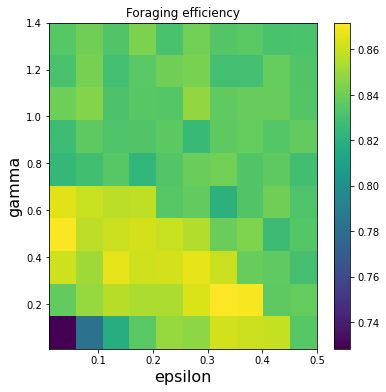

In [16]:
# Figure out some params for plotting depending on the simtype
if simtype == 'qlearning':
    xlst = epslst
    ylst = gammalst
    xlabel = 'epsilon'
    ylabel = 'gamma'
    
    
elif simtype == 'inf-based':
    xlst = prewlst
    ylst = pswitchlst
    xlabel = r'$P_{reward}$'
    ylabel = r'$P_{switch}$'

# Plot of foraging efficiency
plt.figure(figsize=(6, 6))
plt.imshow(efflist, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(xlst), max(xlst), min(ylst), max(ylst)])
plt.colorbar()

fontdict = {'fontsize': 16,
 'fontweight': 2}

plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Foraging efficiency')


Text(0.5, 1.0, 'Left lapse')

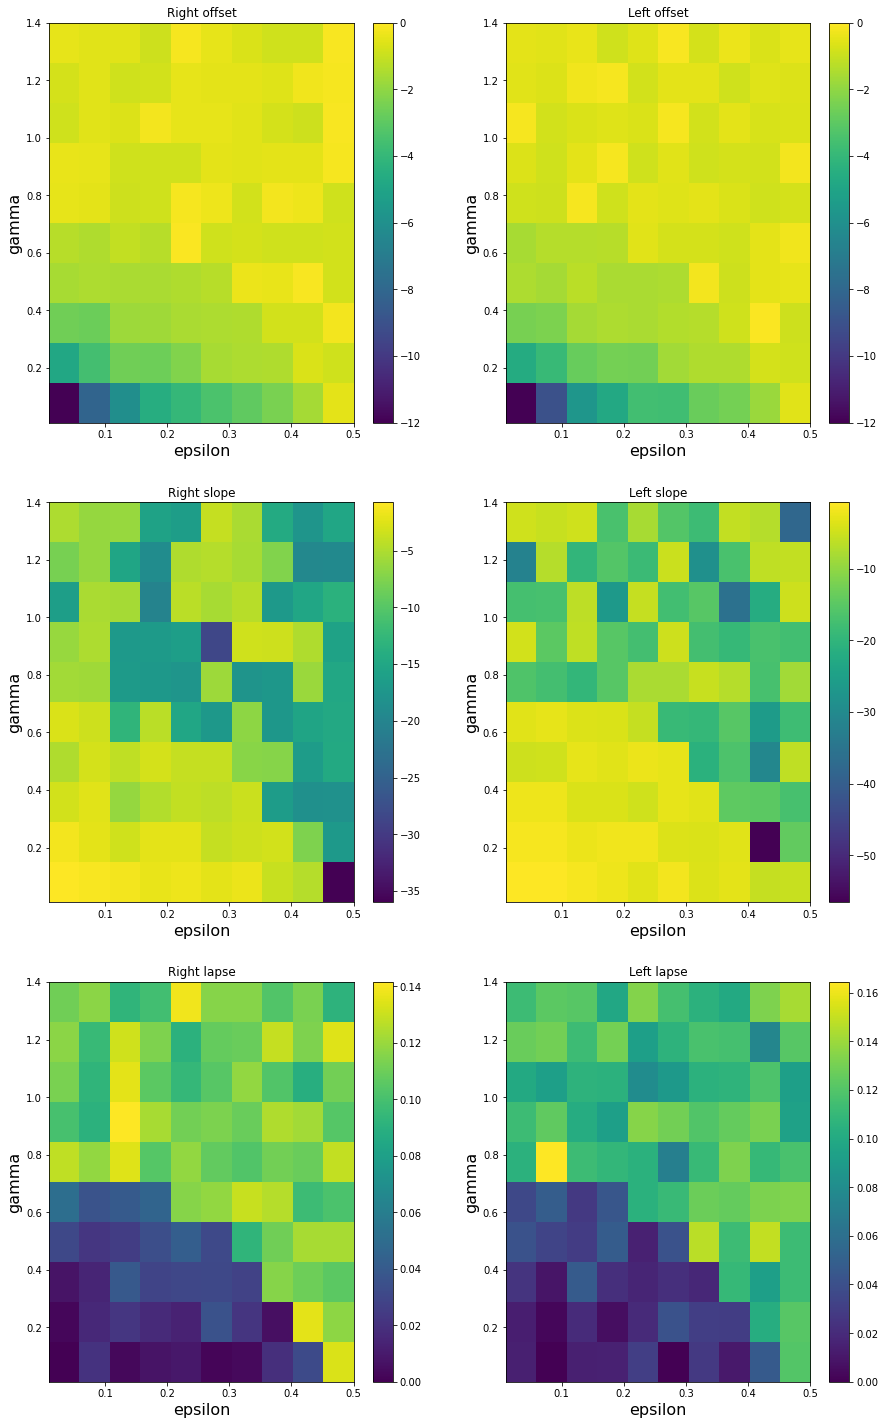

In [17]:
# Plot of foraging efficiency
plt.figure(figsize=(15, 25))
plt.subplot(321)
plt.imshow(PRoffsetlist, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
          vmin=-12, vmax=0)
plt.colorbar()

fontdict = {'fontsize': 16,
 'fontweight': 2}

plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Right offset')


# Plot of transition probability
plt.subplot(322)
plt.imshow(PLoffsetlist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
           vmin=-12, vmax=0
          )
plt.colorbar()
plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Left offset')

plt.subplot(323)
plt.imshow(PRslopelist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
           
          
        )
plt.colorbar()
plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Right slope')


plt.subplot(324)
plt.imshow(-PLslopelist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
           
          )
plt.colorbar()
plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Left slope')

plt.subplot(325)
plt.imshow(LapseR, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
          )
plt.colorbar()

fontdict = {'fontsize': 16,
 'fontweight': 2}

plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Right lapse')


# Plot of transition probability
plt.subplot(326)
plt.imshow(LapseL, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(xlst), max(xlst), min(ylst), max(ylst)],
           
          )
plt.colorbar()
plt.xlabel(xlabel, fontdict)
plt.ylabel(ylabel, fontdict)
plt.title('Left lapse')


## Errors vs previous reward correlation
Here we look at the criterion in Mainen's paper: correlation between switch latency and previous reward

In [ ]:
def get_zstates(agent):
    '''
    Fit HMM to the choice sequence of the agent
    Returns: the sequence of the most likely z-states
    '''
    # Fit HMM to choice sequence
    data = np.array(agent.choice_history)[:,None] 

    ## testing the constrained transitions class
    hmm = ssm.HMM(num_states, obs_dim, observations="bernoulli")
    hmm_lls = hmm.fit(data, method="em", num_iters=N_iters, init_method="kmeans", verbose=0)
    
    return hmm.most_likely_states(data)



    
    
def get_switch_times(world, agent):
    '''
    Returns an array of switching times (in trials),
    based on the HMM model fits
    '''
    z_states = get_zstates(agent)
    splits = split_by_trials(z_states, ntrials, chop='min')
    # Identify where the switch happens
    first_side=world.side_history[0][0]
    
    switchlst = []
    for i in range(len(splits)):
        arr = splits[i]

        # Skip trials that start on the wrong side
        if arr[0] == (first_side + i) % 2:
            switch = -1
            #print('skipping')
        else:
            # Find the first element that is the opposite state
            target = (i + first_side) % 2
            if i % 2 == 0:
                cands = np.where(arr == target)[0]
                if len(cands) == 0:
                    switch = ntrials[i]
                else:
                    switch = cands[0]

        switchlst.append(switch)
    
    return np.array(switchlst)

In [105]:
# np.random.seed(123)
np.random.seed(127)
rlow = 0
rhigh = 1
nblocks = 100
# ntrials_per_block = [50, 80]
ntrials_per_block = [5, 12]
prew = 0.9
psw = 0.1
eps = 0.1
gamma = 0.8
world, ntrials = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
agent = EGreedyQLearningAgent(gamma=gamma, eps=eps)
exp = Experiment(agent, world)
exp.run()  
choice = agent.choice_history
# Find where the block transitions happen
window = 20
side_history = np.array(world.rate_history)[:,0]
blocktrans = np.where(np.diff(side_history) != 0)[0][:-1]
# Get the choices around the transition
choicelst = split_by_trials(agent.choice_history, ntrials, chop='max')

z_states = get_zstates(agent)
#splits = split_by_trials(z_states, ntrials, chop=False)
lst = get_switch_times(world, agent)

NameError: name 'get_zstates' is not defined

In [ ]:
# See the dependence between number of consec rewards vs number of consec errors
choices = agent.choice_history

In [ ]:
plt.imshow(choicelst, aspect='auto')

In [ ]:
plt.imshow(choicelst, aspect='auto')

In [ ]:
choicelst

In [ ]:
# Is there a correlation?
nafterswitch = ntrials - lst
plt.plot(nafterswitch[:-1], lst[1:], '.')

In [ ]:
plt.plot(lst)

In [ ]:
plt.imshow(splits[:72,:], aspect='auto')

In [ ]:
# Identify where the switch happens
first_side=world.side_history[0][0]
for i in range(len(splits)):
    arr = splits[i]
    
    # Skip trials that start on the wrong side
    if arr[0] == (first_side + i) % 2:
        switch = -1
        print('skipping')
    else:
        # Find the first element that is the opposite state
        target = (i + first_side) % 2
        if i % 2 == 0:
            cands = np.where(arr == target)[0]
            if len(cands) == 0:
                switch = ntrials[i]
            else:
                switch = cands[0]
        
    print(switch)
        

In [ ]:
# Fit HMM to choice sequence
data = np.array(agent.choice_history)[:,None] 

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="bernoulli")
hmm_lls = hmm.fit(data, method="em", num_iters=N_iters, init_method="kmeans", verbose=0)

In [ ]:
M,N,P = hmm.expected_states(data)

In [ ]:
len(agent.choice_history)

In [ ]:
plt.plot(M[:300,:])
plt.plot(hmm_z[:300])

In [ ]:
hmm_z = hmm.most_likely_states(data)

#Let's get the emission probs
T = hmm.transitions.transition_matrix

In [ ]:
M = hmm.observations.log_likelihoods(data, None, None, None)
plt.plot(M[:100,:])

In [ ]:
plt.plot(hmm_z[:600])
plt.plot(side_history[:600])

In [ ]:
choicearr = np.array(choicelst)
choicearr.shape

In [ ]:
plt.plot(choicearr[:,8])

In [212]:
# For debugging...
rlow = 0.1
rhigh = 0.9
nblocks = 100
ntrials_per_block = [30, 40]
prew = 0.9
psw = 0.2
eps = 0
# world = ForagingWorld(prew=0.9, psw=0.05, pstruct=[10, 50], nblockmax=100)
world,_ = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
agent = EGreedyQLearningAgent(gamma=0.6, eps=0.3)
exp = Experiment(agent, world)
exp.run()  

([0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [285]:
N_iters = 50
num_states = 2
obs_dim = 1
rlow = 0.1
rhigh = 0.9
nblocks = 100
ntrials_per_block = [50, 80]

world,_ = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
agent = EGreedyInferenceBasedAgent(prew=0.9, pswitch=0.1, eps=0)
exp = Experiment(agent, world)
exp.run()  

([1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,


In [286]:
find_LR_transition_fit(world, agent, 15)

(array([-5.79242667, -0.49967129,  0.12001928]),
 array([ 8.05137306, -0.30634037,  0.09692759]))

In [275]:
choicelst = split_by_trials(np.array(agent.choice_history), world.ntrialblocks[:-1], chop='min')
fit_sigmoidal(choicelst, False)

/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/utils.py:38: RuntimeWarning: overflow encountered in exp
  preds = lapse + (1 - 2 * lapse) * 1 / (1 + np.exp(-p[0] * (x + p[1])))


(array([-15.93327829,  -0.7210285 ,   0.11101987]),
 array([14.71399924, -0.87172601,  0.1200118 ]))

In [270]:
leftAverage = np.nanmean(choicelst[1::2, :], axis=0)
rightAverage = np.nanmean(choicelst[::2, :], axis=0)

In [284]:
world.rate_history[0][0]

0.9

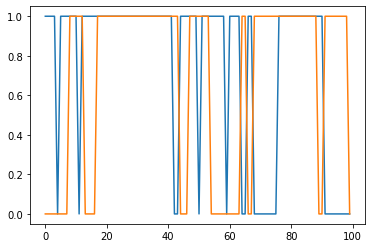

In [279]:
plt.plot(world.side_history[:100])

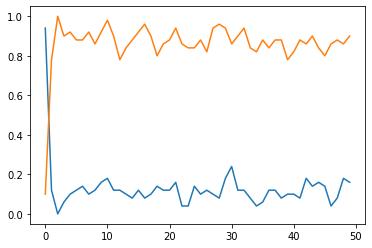

In [274]:
plt.plot(rightAverage)
plt.plot(leftAverage)

In [272]:
world.side_history[0][0]

True

In [259]:
world.side_history[0][0]

True